# Machine Learning Project - Schlaganfallrisiko

In [ ]:
import sys
assert sys.version_info >= (3, 7)
import sklearn #"scikit-learn"
assert sklearn.__version__ >= "1.2"
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
assert pd.__version__ >="1.5.0"

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns







In [2]:
# lies CSV Daten ein
df = pd.read_csv('healthcare-dataset-stroke-data.csv',
                 encoding='utf-8',  
                 delimiter=',',     
                 header=0)
pd.set_option("display.max_columns", None)

# ID column wird aus Datensatz entfernt
df = df.iloc[:,1:]

print("Spaltennamen","\n",df.columns,"\n")
df_empty = df[df.isnull().any(axis=1) ]

print(df["work_type"].value_counts(),"\n")
print(df["Residence_type"].value_counts(),"\n")
print("Fehlende BMI Werte",df["bmi"].isnull().sum(),"\n")
print(df["smoking_status"].value_counts(),"\n")
print(df["ever_married"].value_counts(),"\n")
# Smoking status für Kinder unter 20 
print("value counts smoking in the young","\n",df[(df['age'].astype(np.int8) < 20)]["smoking_status"].value_counts())

# print(df_empty)





Spaltennamen 
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object') 

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64 

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64 

Fehlende BMI Werte 201 

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64 

ever_married
Yes    3353
No     1757
Name: count, dtype: int64 

value counts smoking in the young 
 smoking_status
Unknown            731
never smoked       187
formerly smoked     29
smokes              19
Name: count, dtype: int64


**Einteilung der Daten** 
- in Patienten, die einen Stroke hatten vs. keinen Stroke:

In [3]:
df_stroke = df[df['stroke'].astype(np.int8) == 1]
print(df_stroke.shape)
df_Nostroke = df[df['stroke'].astype(np.int8) == 0]
print(df_Nostroke.shape)

(249, 11)
(4861, 11)


Sehr starkes Ungleichgewicht in den Daten. 250 Stroke Patienten vs 4861 Patienten ohne Stroke.
- Stratifizierung der Daten zwischen Trainings- und Testdaten.
- größere Gewichtung auf die Daten der Stroke Patienten

**Spalteneinschätzung**
1. Wie sehr eignen sich die Spalten für das Ziel der Untersuchung? 
2. Welchen Erklärungswert haben diese eigentlich?
3. Was könnte mit dem Labeling gemeint sein?

## Medizinische Indikatoren

**age** numeric -- sinnvolle Spalte, 
- Die Wahrscheinlichkeit für einen Schlaganfall erhöht sich mit zunehmendem Alter.

**Blutzucker** numerical -- sinnvoll für unsere Fragestellung
- erhöhter Blutzucker beschädigt Blutgefäße und kann dadurch zu Gerinnseln führen. Diese können einen Schlaganfall auslösen

**hypertension** categorical -- sinnvolle Spalte für die Fragestellung, 
- Die Einnahme von Medikamenten, die Blutdruck senken, können das Risiko für einen Schlaganfall signifikant senken.

**heart disease** categorical -- sinnvolle Spalte für Fragestellung
- viele/die meisten Herzkrankheiten stehen mit einem Risiko für einen Schlaganfall in Verbindung
  $\rightarrow$ Blutgerinnseln führen, die einen Schlaganfall auslösen können.

**bmi** numerical -- sinnvoll, um Risiko für Schlaganfälle abzuschätzen
- $\rightarrow$ korreliert mit Diabetes und Hypertension, die etablierte Risikofaktoren für Schlaganfälle sind
- 201 von 5110 keine Wertangabe
- fehlende Werte transputen

**Smoking Status** categorical -- sinnvoll, um Risiko für Schlaganfälle einschätzen zu können
- Arterienverengung, Risiko der Entstehung von Blutgerinnseln, die zu Schlaganfällen führen können
- Aufteilung der Daten zu erwägen:
- $\rightarrow$ großer Anteil der Daten "Unknown" und "Never Smoked" werden von den Kindern übernommen
- $\rightarrow$ im Datensatz sind nur 2 Kinder aufgeführt, die einen Schlaganfall hatten
- $\rightarrow$ eventuell alle Kinder entfernen, um das Risiko des Rauchstatus aus dem Datensatz besser einschätzen zu können

## Stressfaktoren

**ever married** -- So wie Daten hier stehen ist diese Spalte nicht sinnvoll.
- unklar, ob gerade verheiratet sind oder verheiratet waren
  - Unterscheidung kann direkt Stresslevel aufheben
- Kinder sollten hier getrennt werden
- Datensatz sehr unbalanziert

**gender** categorical -- möglich sinvolle Spalte
- Schlaganfallrisiko bei Frauen im höheren Alter größer, da diese länger leben (gibt dann keine Männer mehr)
- Schlaganfallrisiko bei Männer im mittleren Alter größer
- Interaktion Männer und Frauen mit Alter
- schwierig diesen Zusammenhang sinnvoll in den Daten zu beobachten
  
**work type** ordinal -- Stresslevel?
$\rightarrow$ Rücksprache mit den Erstellern der Datenbank
- großes Ungleichgewicht der Daten
- ist "Private" gleichzusetzen mit "Keine Angabe"
- "children": entfernen? deren Stresslevel nicht von derem Employmentstatus abhängig 
- "self-employed" stressiger als "Gov. job" -- 
- aufwändige Datenvorbereitung 

**residence type** categorical -- Stresslevel
- $\rightarrow$ Leben auf dem Land mehr mit Natur und Aktivität verbunden
- gut ausbalanzierte Informationen im Datensatz



# Einteilung der Patienten: Stroke vs No-Stroke
Korrelationsplots der numerischen Daten für alle Patienten und für die Strokepatienten

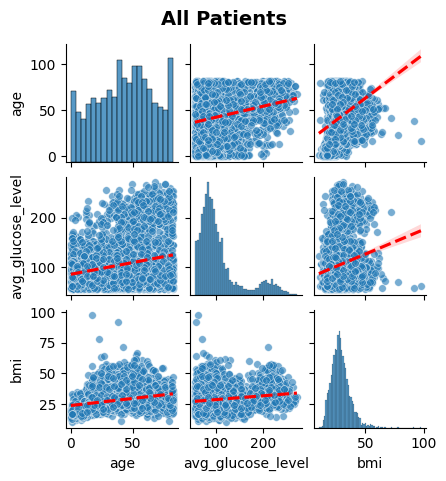

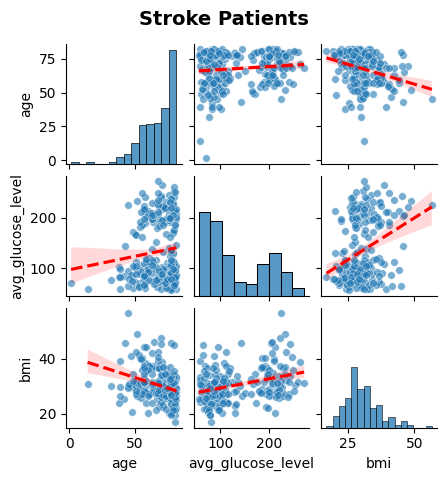

In [4]:
attributes = ["age", "avg_glucose_level", "bmi"]

# pairplot with regression lines and confidence intervals
g = sns.pairplot(df[attributes], 
                 diag_kind='hist',
                 plot_kws={'alpha': 0.6, 's': 30},
                 height=1.5)

g.fig.suptitle('All Patients', 
               y=1.05, fontsize=14, fontweight='bold')

# Add regression lines with confidence intervals
g.map_upper(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})
g.map_lower(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})

plt.show()

attributes = ["age", "avg_glucose_level", "bmi"]

# Using seaborn's pairplot with regression lines and confidence intervals
g = sns.pairplot(df_stroke[attributes], 
                 diag_kind='hist',
                 plot_kws={'alpha': 0.6, 's': 30},
                 height=1.5)

g.fig.suptitle('Stroke Patients', 
               y=1.05, fontsize=14, fontweight='bold')

# Add regression lines with confidence intervals
g.map_upper(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})
g.map_lower(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})

plt.show()

- Der Unterschied zwischen den Plots ist auch durch die geringere Anzahl der Strokepatienten deutlich sichtbar.
- Man sieht deutlich unterschiedliche Muster in allen 3 Spalten. Wobei besonders auffällt, dass ein Stroke vor allem mehr ältere äPatienten betrifft.
- Beim Blutzuckerspiegel fällt auf, dass sich die Stroke Patienten 2 Gruppen zu bilden scheinen (high $\leftrightarrow$ low sugar). 

# Altersverteilung
1. Alle Patienten
2. Gesunde Patienten
3. Stroke Patienten

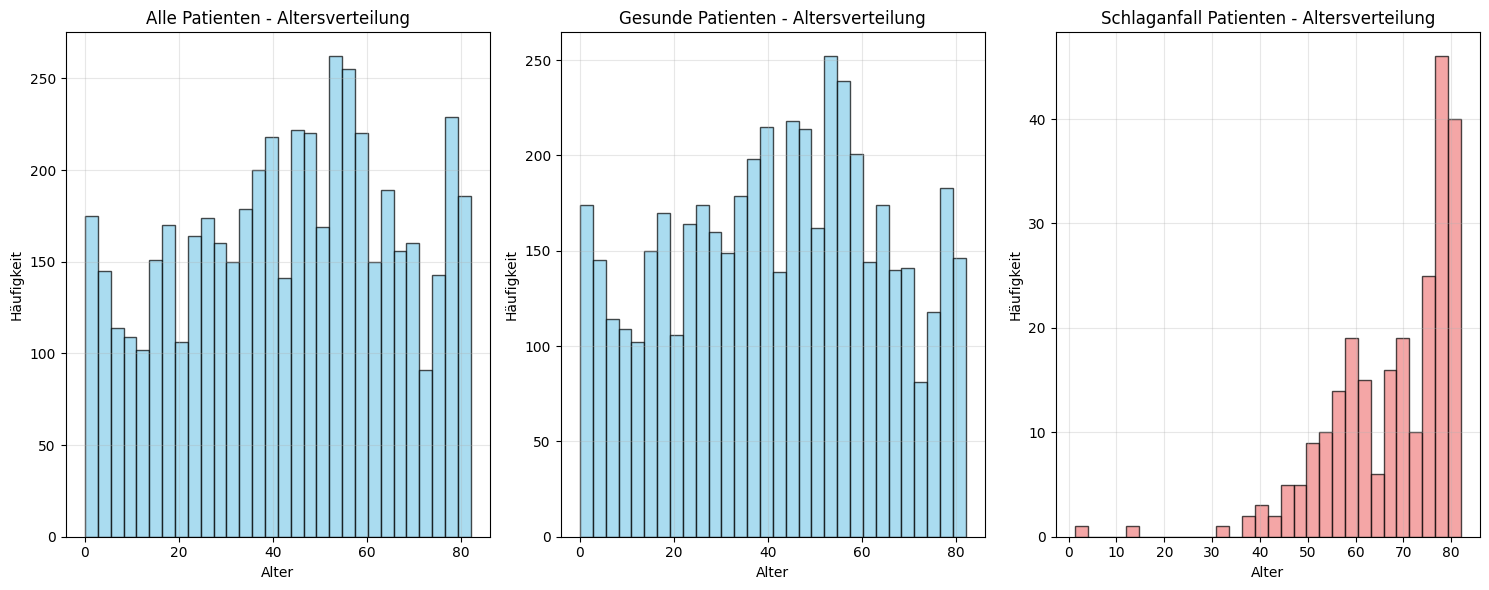

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

# First histogram - All patients
ax1.hist(df["age"], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Alter')
ax1.set_ylabel('Häufigkeit')
ax1.set_title('Alle Patienten - Altersverteilung')
ax1.grid(True, alpha=0.3)


ax2.hist(df_Nostroke["age"], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_xlabel('Alter')
ax2.set_ylabel('Häufigkeit')
ax2.set_title('Gesunde Patienten - Altersverteilung')
ax2.grid(True, alpha=0.3)


# Second histogram - Stroke patients
ax3.hist(df_stroke["age"], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
ax3.set_xlabel('Alter')
ax3.set_ylabel('Häufigkeit')
ax3.set_title('Schlaganfall Patienten - Altersverteilung')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Es gibt nur 2 Kinder mit Schlaganfall im gesamten Datensatz. Das Alter scheint besonders hohes Risiko für einen Schlaganfall zu sein.

# Faktor Kinder?

Bei der Abspaltung der Stroke Patienten hat sich ein Bild gezeigt:
- Verteilung des Alters der Patienten ist rechtssteil - dadurch verteilen sich viele der relevanten Daten auf die Erwachsenen (evtl cut bei 20 Jahren)
- es gibt nur 2 Kinder, die einen Schlaganfall in unserem Datensatz hatten
Einzelfall:
- diese Kinder hatten einen geringen Blutzucker

In [6]:
# remove gender - Alter one-hot coding? 
df_child = df[df["age"].astype(np.int8) <= 20]
df_adult = df[df["age"].astype(np.int8) > 20]

# print out the data for the 2 children that suffered a stroke
df_child_stroke = df[(df["age"].astype(np.int8) < 20) & (df["stroke"].astype(np.int8) == 1)]
print(df_child_stroke)



     gender    age  hypertension  heart_disease ever_married work_type  \
162  Female   1.32             0              0           No  children   
245  Female  14.00             0              0           No  children   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  
162          Urban              70.37   NaN        Unknown       1  
245          Rural              57.93  30.9        Unknown       1  


Kinder sind nicht nur bei den Stroke Patienten kaum vertreten, sie machen auch einen großen Teil der "unknown" und "never-smoked" Daten aus. 
Wenn Kinder im Datensatz bleiben, wird auch die Interpretation dieser Spalte schwierig.

In [7]:

print("Allgmeine Info zu Smoking Status","\n",df["smoking_status"].value_counts(),"\n")

# print out the value counts for the smoking status column for people below 25 
print("Info zum smoking bei Kindern unter 25","\n",df[(df['age'].astype(np.int8) < 25)]["smoking_status"].value_counts())

Allgmeine Info zu Smoking Status 
 smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64 

Info zum smoking bei Kindern unter 25 
 smoking_status
Unknown            789
never smoked       323
smokes              68
formerly smoked     56
Name: count, dtype: int64


Kinder verzerren auch die Info, wie sich der Work_type auf das Schlaganfallrisiko auswirken kann.

In [8]:
print("Work Type:","\n",df["work_type"].value_counts())

Work Type: 
 work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64



Unter der Annahme, dass die Angabe "Private" eigentlich den Status "employed" darstellt, sind die Daten hier auch sehr unbalanziert. 
Viele Kinder aufgeführt. Weiteres Argument: Kinder aus der Analyse rauszunehmen.

# Blutzuckerverteilung 
Vergleich 
1. alle Patienten
2. gesunde Patienten
3. stroke Patienten

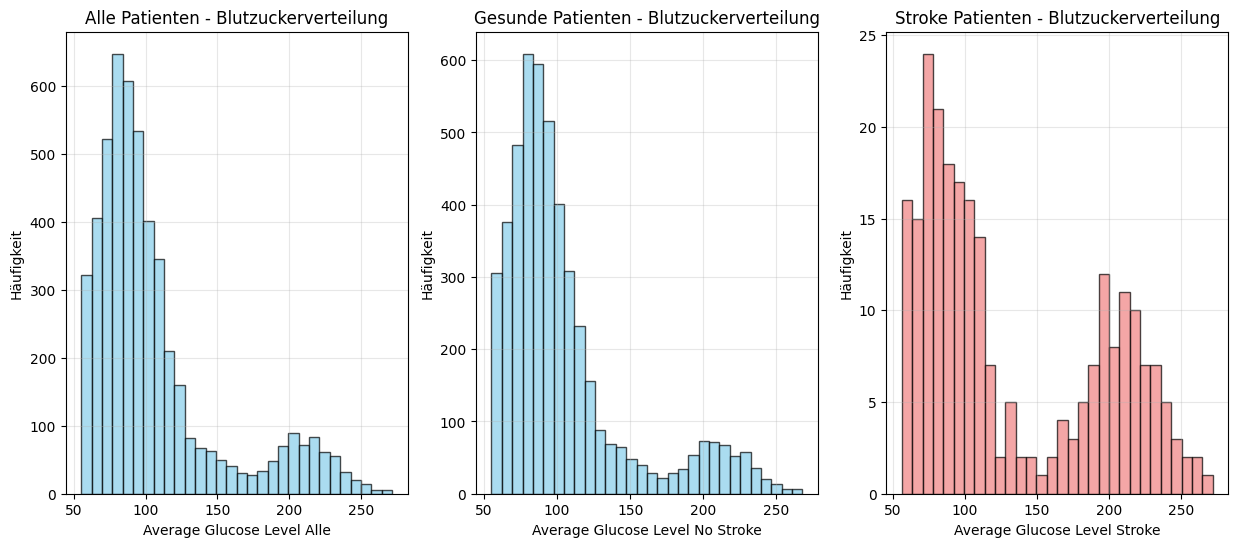

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.hist(df["avg_glucose_level"], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Average Glucose Level Alle')
ax1.set_ylabel('Häufigkeit')
ax1.set_title('Alle Patienten - Blutzuckerverteilung')
ax1.grid(True, alpha=0.3)

ax2.hist(df_Nostroke["avg_glucose_level"], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_xlabel('Average Glucose Level No Stroke')
ax2.set_ylabel('Häufigkeit')
ax2.set_title('Gesunde Patienten - Blutzuckerverteilung')
ax2.grid(True, alpha=0.3)


ax3.hist(df_stroke["avg_glucose_level"], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
ax3.set_xlabel('Average Glucose Level Stroke')
ax3.set_ylabel('Häufigkeit')
ax3.set_title('Stroke Patienten - Blutzuckerverteilung')
ax3.grid(True, alpha=0.3)
plt.show()


In [10]:
print(df["avg_glucose_level"].describe())
df["avg_glucose_level"].median()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64


91.88499999999999

Mittelwert und Median von Blutzucker weichen in der Gruppe der Stroke Patienten stark voneinander ab. Diese Polynomialverteilung zeigt sich auch in den Plots.
Um weitere Muster zu erkennen, werden die Patienten in 3 Gruppen eingeteilt:
1. low glucose level
2. normal glucose level
3. high glucose level

In [11]:
df_lowsugar = df_stroke[df_stroke["avg_glucose_level"] <= 85]
#print(df_lowsugar.shape, df_lowsugar["stroke"].value_counts())
df_normalsugar = df_stroke[(df_stroke["avg_glucose_level"] > 85) & (df_stroke["avg_glucose_level"] <120)]
#print(df_normalsugar.shape, df_normalsugar["stroke"].value_counts())
df_highsugar = df_stroke[(df_stroke["avg_glucose_level"] >= 120)]
#print(df_highsugar.shape, df_highsugar["stroke"].value_counts())

df_lowsugar_all = df[df["avg_glucose_level"] <= 85]
df_normalsugar_all = df[(df["avg_glucose_level"] > 85) & (df_stroke["avg_glucose_level"] < 120)]
df_highsugar_all = df[(df["avg_glucose_level"] >= 120)]



In [12]:
corr_lowsugar = pd.DataFrame(df_lowsugar.corr(numeric_only = True))
#print(corr_lowsugar, corr_lowsugar.shape)
corr_normalsugar = pd.DataFrame(df_normalsugar.corr(numeric_only = True))
#print(corr_normalsugar, corr_normalsugar.shape)
corr_highsugar = pd.DataFrame(df_highsugar.corr(numeric_only = True))
#print(corr_highsugar,corr_highsugar.shape)


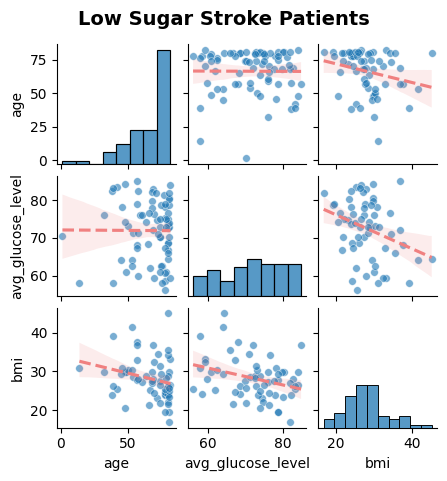

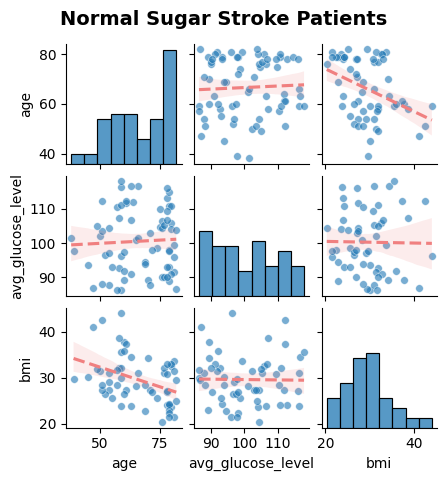

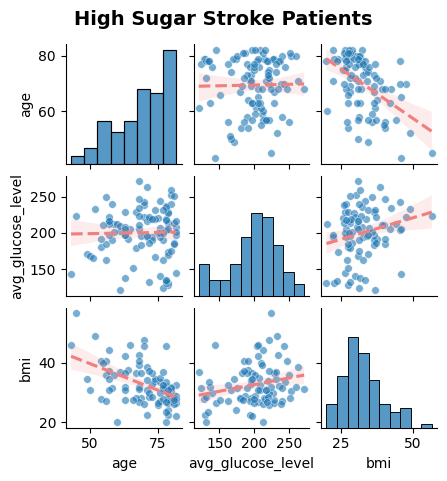

In [13]:
import seaborn as sns

attributes = ["age", "avg_glucose_level", "bmi"]

# Using seaborn's pairplot with regression lines and confidence intervals
g = sns.pairplot(df_lowsugar[attributes], 
                 diag_kind='hist',
                 plot_kws={'alpha': 0.6, 's': 30},
                 height=1.5)

g.fig.suptitle('Low Sugar Stroke Patients', 
               y=1.05, fontsize=14, fontweight='bold')

# Add regression lines with confidence intervals
g.map_upper(sns.regplot, scatter=False, color='lightcoral', line_kws={'linestyle': '--'})
g.map_lower(sns.regplot, scatter=False, color='lightcoral', line_kws={'linestyle': '--'})

plt.show()


g = sns.pairplot(df_normalsugar[attributes], 
                 diag_kind='hist',
                 plot_kws={'alpha': 0.6, 's': 30},
                 height=1.5)
g.fig.suptitle('Normal Sugar Stroke Patients', 
               y=1.05, fontsize=14, fontweight='bold')

g.map_upper(sns.regplot, scatter=False, color='lightcoral', line_kws={'linestyle': '--'})
g.map_lower(sns.regplot, scatter=False, color='lightcoral', line_kws={'linestyle': '--'})

plt.show()


g = sns.pairplot(df_highsugar[attributes], 
                 diag_kind='hist',
                 plot_kws={'alpha': 0.6, 's': 30},
                 height=1.5)
g.fig.suptitle('High Sugar Stroke Patients', 
               y=1.05, fontsize=14, fontweight='bold')

g.map_upper(sns.regplot, scatter=False, color='lightcoral', line_kws={'linestyle': '--'})
g.map_lower(sns.regplot, scatter=False, color='lightcoral', line_kws={'linestyle': '--'})

plt.show()

# Findings
Stroke Patienten in 3 Bloodzuckergruppen geteilt: (1) low, (2) normal, (3) high

Die Richtung der Korrelation zwischen Blutzucker und BMI (siehe jeweils 3. Spalte 2. Zeile).

Besonders interessant ist der Unterschied in der Korrelation zwischen BMI und Glucose Level. Bei den (1.) low-sugar Patienten ist diese negativ (je größer der Glucose Wert, desto geringer der BMI), bei den (2.) normalen gibt es keinen Zusammenhang zwischen Glucose und BMI, bei den (3.) high-sugar Patienten gibt es eine positive Korrelation (hoher Zucker korreliert mit hohem BMI).

$\rightarrow$ Information, dass niedriger Blutzucker auch Risiko für Stroke ist. Diese Info nicht im gesamten Datensatz. Coding von Blutzucker ändern, um diese Info zu erhalten?

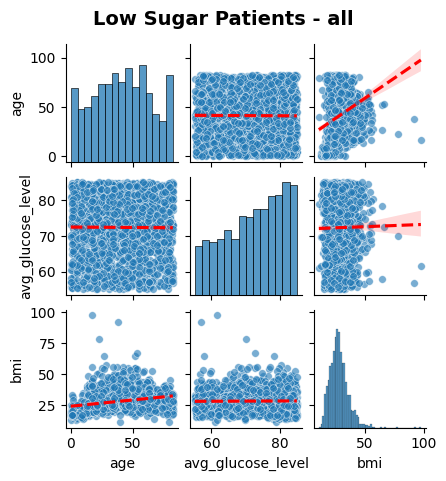

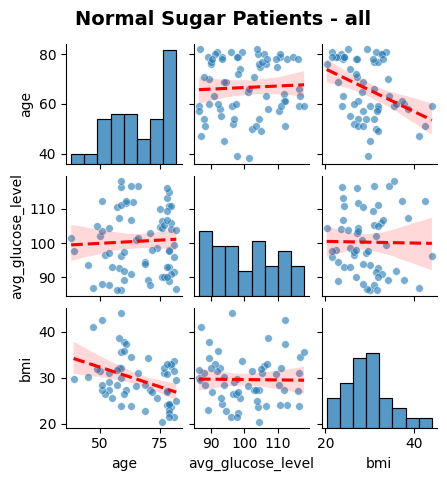

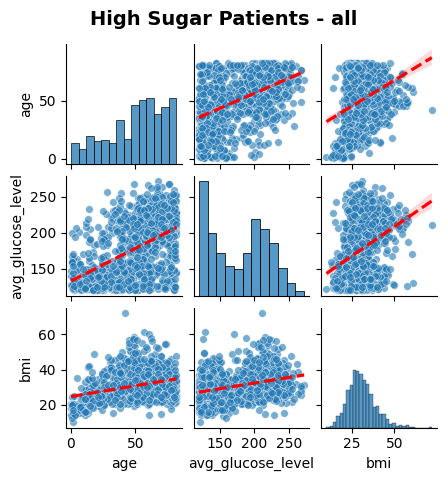

In [15]:

# 3 Gruppeneinteilungen Glucose über alle Patienten verteilt

attributes = ["age", "avg_glucose_level", "bmi"]

# Scatterplots with regression lines and confidence intervals
g = sns.pairplot(df_lowsugar_all[attributes], 
                 diag_kind='hist',
                 plot_kws={'alpha': 0.6, 's': 30},
                 height=1.5)

g.fig.suptitle('Low Sugar Patients - all', 
               y=1.05, fontsize=14, fontweight='bold')

g.map_upper(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})
g.map_lower(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})

plt.show()

g = sns.pairplot(df_normalsugar_all[attributes], 
                 diag_kind='hist',
                 plot_kws={'alpha': 0.6, 's': 30},
                 height=1.5)
g.fig.suptitle('Normal Sugar Patients - all', 
               y=1.05, fontsize=14, fontweight='bold')

g.map_upper(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})
g.map_lower(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})

plt.show()

g = sns.pairplot(df_highsugar_all[attributes], 
                 diag_kind='hist',
                 plot_kws={'alpha': 0.6, 's': 30},
                 height=1.5)
g.fig.suptitle('High Sugar Patients - all', 
               y=1.05, fontsize=14, fontweight='bold')

g.map_upper(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})
g.map_lower(sns.regplot, scatter=False, color='red', line_kws={'linestyle': '--'})

plt.show()

# Barplots


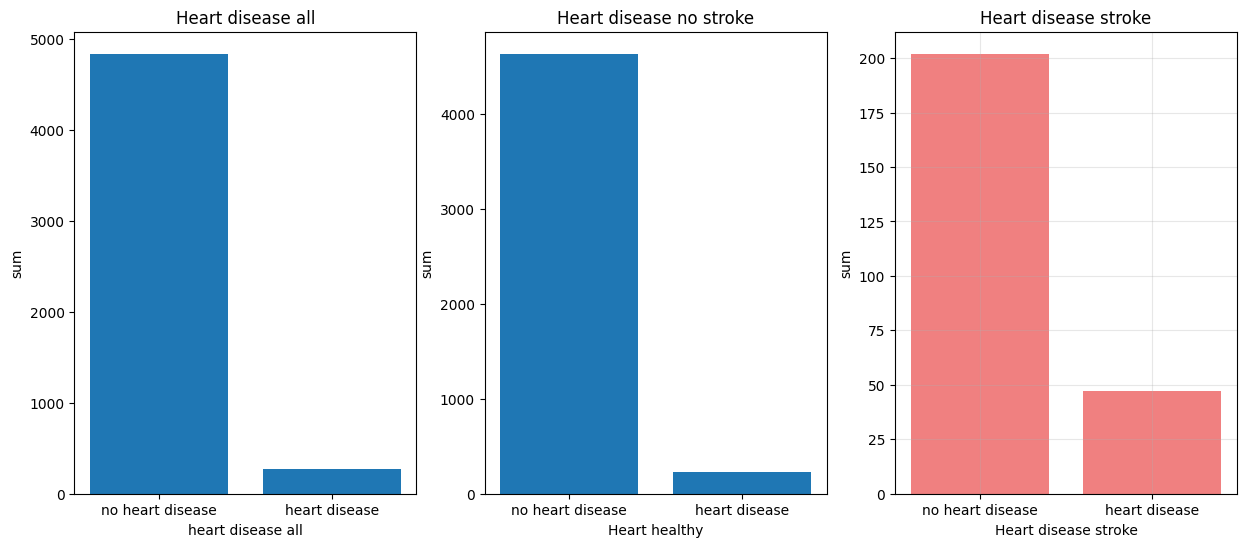

In [16]:
heart_disease = df["heart_disease"].value_counts()
heart_disease_Nostroke = df_Nostroke["heart_disease"].value_counts()
heart_disease_stroke = df_stroke["heart_disease"].value_counts()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.bar(["no heart disease","heart disease"],heart_disease)
ax1.set_xlabel('heart disease all')
ax1.set_ylabel('sum')
ax1.set_title('Heart disease all')

ax2.bar(["no heart disease","heart disease"],heart_disease_Nostroke)
ax2.set_xlabel('Heart healthy')
ax2.set_ylabel('sum')
ax2.set_title('Heart disease no stroke')


ax3.bar(["no heart disease","heart disease"],heart_disease_stroke,color='lightcoral')
ax3.set_xlabel('Heart disease stroke')
ax3.set_ylabel('sum')
ax3.set_title('Heart disease stroke')
ax3.grid(True, alpha=0.3)
plt.show()


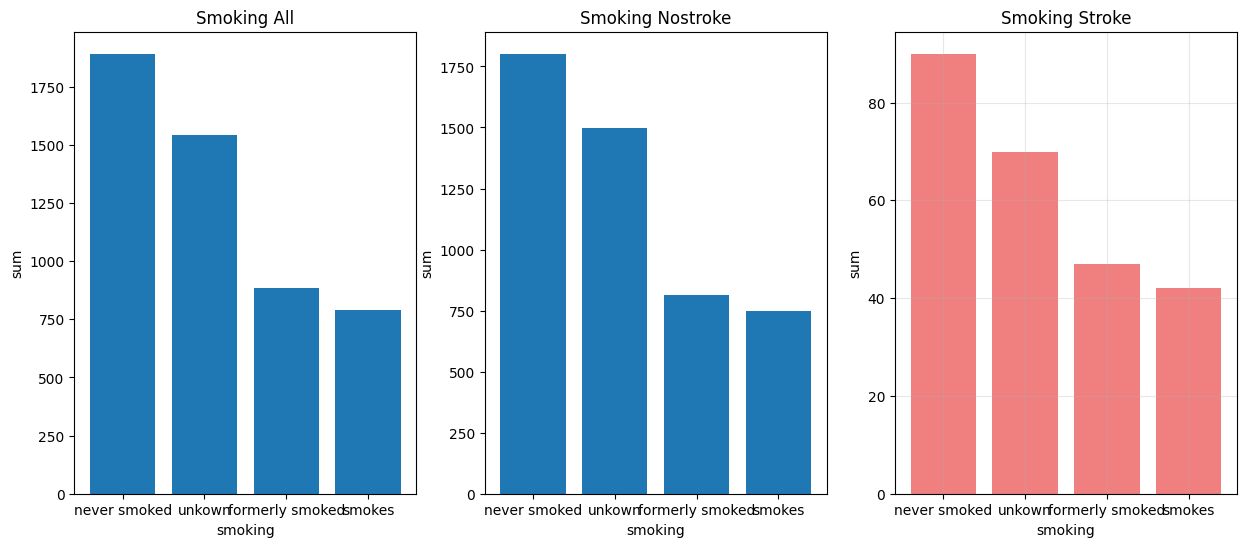

In [17]:

smoke_stroke = df_stroke["smoking_status"].value_counts()
smoke_Nostroke = df_Nostroke["smoking_status"].value_counts()
smoke_all = df["smoking_status"].value_counts()

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.bar(["never smoked","unkown","formerly smoked","smokes"],smoke_all)
ax1.set_xlabel('smoking')
ax1.set_ylabel('sum')
ax1.set_title('Smoking All')


ax2.bar(["never smoked","unkown","formerly smoked","smokes"],smoke_Nostroke)
ax2.set_xlabel('smoking')
ax2.set_ylabel('sum')
ax2.set_title('Smoking Nostroke')

ax3.bar(["never smoked","unkown","formerly smoked","smokes"],smoke_stroke,color='lightcoral')
ax3.set_xlabel('smoking')
ax3.set_ylabel('sum')
ax3.set_title('Smoking Stroke')
ax3.grid(True, alpha=0.3)
plt.show()

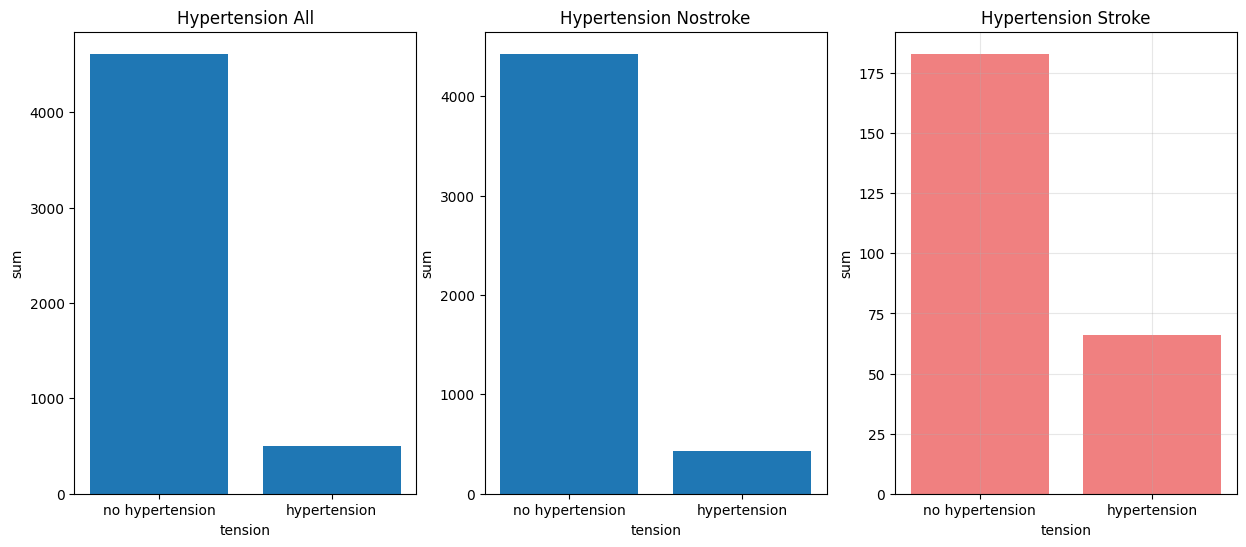

In [18]:
tension_stroke = df_stroke["hypertension"].value_counts()
tension_Nostroke = df_Nostroke["hypertension"].value_counts()
tension_all = df["hypertension"].value_counts()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.bar(["no hypertension","hypertension"],tension_all)
ax1.set_xlabel('tension')
ax1.set_ylabel('sum')
ax1.set_title('Hypertension All')

ax2.bar(["no hypertension","hypertension"],tension_Nostroke)
ax2.set_xlabel('tension')
ax2.set_ylabel('sum')
ax2.set_title('Hypertension Nostroke')

ax3.bar(["no hypertension","hypertension"],tension_stroke,color='lightcoral')
ax3.set_xlabel('tension')
ax3.set_ylabel('sum')
ax3.set_title('Hypertension Stroke')
ax3.grid(True, alpha=0.3)
plt.show()


In [19]:
#Gender

#stroke_F = (df_stroke['gender'] == 'Female').value_counts()
#stroke_M = (df_stroke['gender'] == 'Male').value_counts()
#df_stroke = df[df['stroke'].astype(np.int8) == 1]
#df_Nostroke = df[df['stroke'].astype(np.int8) == 0]

|**Datensatz**|
|---|
|unbalanziert|
|Datatyp: nominal + categorisch + binär|
|kleiner Datensatz|
|viele fehlende Werte| 
|Keine gleichmäßige Streuung der Abweichungen|
|Haben auch lineare ZUsammenhänge in den Daten (Glucose Level zu Stroke)| 


|**lineare Algorithmen**|**linear Regression**
|---|---|
|Linearität zu berechnenden Parametern|nicht robust gegen Ausreisser (spezielle Klassen dafür möglich)|
|Skalierung bei einigen Variablen notwendig|auch nicht-lineare Zusammenhänge abbildbar|
|gleichmäßige Streuung der Abweichungen nötig|robust gegen Datenfehler|
|Regression aber auch Klassifikation möglich (logistic Regression)|Klassen, die Overfitting vermeiden|

**Vorhersage Datensatz**

Nicht sehr gut geeignet für unseren Datensatz:
- **-** $\rightarrow$ Klassifikation nur mit logistic Regression möglich
- **-** keine gleichmäßige Abweichung bei der Streuung vom Mittelwert (homoscedacity) - siehe scatterplots mit Abweichungen vom Mittelwert
- **-** Gefahr von Overfitting beachten, besondere Klassen berücksichtigen
- **+** nicht lineare Zusammenhänge abbildbar
- 

|**Bayes**|**knearest**|
|---|---|
|Features unabhängig|wenig Spalten|
|PCA in der Datenvorbereitung|Skalierung wichtig|
|Zielspalte: Klassifikation|Klassifikation + Regression möglich|
|robust gegen Ausreißer|kategorische Daten möglich/Interpolation bei metrischen Daten|
|Gewichtung der Spalten schwierig|robust gegen Ausreisser|
|wenig Parameter, die noch angepasst werden müssen|keine Gewichtung der Spalten|
|Abhängigkeit der Spalten problematisch - wenn wenig Zeilen|Interaktionen gut verarbeitbar|

**Vorhersage Datensatz für Bayes**

- **-** Gewichtung der Spalten: kann eventuell mit guter Datenvorbereitung, die die Daten balanziert, ausgeglichen werden.
- **-** Features sind nicht unabhängig 
- https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html
- **+** Klassifikation
- **+** PCA in Vorbereitung
- **+** wenig Parameter müssen angepasst werden

**Vorhersage Datensatz knearest**

- Daten skaliert
- **+** Klassifikation möglich
- **+** kategorische Daten /metrische Daten mit Interpolation
- **-** Gewichtung der Spalten nicht möglich -- durch gute Datenvorbereitung evtl. korrigierbar
- **+** Interaktionen gut verarbeitbar




|**Decision Tree**|**SVM**|
|---|---|
|Wahl Spalte und Schwelle: homogene Teilmengen|Trenngerade zwischnen 2 Klassen|
|irrelevante Spalten herausfiltern|lineare Trennbarkeit oder Kernel (erfordert Fachwissen)|
|Klassifikation und Regression|Skalierung / Fokus auf wenige Spalten|
|Gefahr overfitting|Klassifikation und Regression möglich|
|Biasgefahr bei unbalanzierten Daten|Overfitting: meist nein - abhängig von Kernel und Regularisierung|
|Anwendung: Diagnose von Krankheiten|Klassifikation gut/Ausreisser erkennbar
|maximale Tiefe vorher bestimmen|
|ensemble Methoden|
|Datenfilterung oder Gewichtung der Datensätze|

**Vorhersage Datensatz Decision Tree**

- **+** irrelevante Spalten herausfiltern
- **+** Klassifikation
- **+** Gefahr overfitting durch Wahl der Schwelle kontrollierbar
- **-** Biasgefahr durch nicht homogene Daten
- **+** Datenfilterng oder Gewichtung der Datensätze für uns relevant und machbar

**Vorhersage Datensatz SVM**

- **+** Trenngerade zwischen Klassen
- **-** Wahl eines Kernels erfordert Fachwissen
- **+** SKallierung und Fokus auf wenige Spalten (machbar bei unserem Datensatz)
- **+** gut für Klassifikation auch Ausreisser erkennbar

|**Neuronale Netze**|
|---|
|braucht große Datenmengen|
|empfindlich auf Art/Verteilung der Daten|
|Skalierung und nur relevante Spalten mit relevanten Mengenverhältnissen|
|braucht ausbalanzierte Daten|
|Klassifikation und Regression|
|kann komplexe Daten verarbeiten|


**Vorhersage Datensatz neuronale Netze**
- **-** große Datenmengen
- **+** Klassifikation
- **-** braucht ausbalanzierte Daten
- **-** Empfindlichkeit gegenüber Art und Verteilung


**Einschätzung der Algorithmen**

Für unseren Datensatz scheinen die Algorithmen Bayes, knearest, decision tree und SVM am besten geeignet zu sein.